In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available


2.3.1+cpu
False


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import json
import collections

import matplotlib.pyplot as plt

 
import torch


from torch_geometric.data import Data

from torch_geometric.utils.convert import to_networkx

import networkx as nx

In [3]:
with open("C:/Users/satvi/OneDrive/Desktop/proj1-SNA-using-GNN/dataset/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)

edges=pd.read_csv("C:/Users/satvi/OneDrive/Desktop/proj1-SNA-using-GNN/dataset/musae_git_edges.csv")
target_df=pd.read_csv("C:/Users/satvi/OneDrive/Desktop/proj1-SNA-using-GNN/dataset/musae_git_target.csv")#.to_numpy()[:,2]

In [4]:
print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [9]:
print("Connection of edges:")
print(edges.head(5).to_markdown())

Connection of edges:
|    |   id_1 |   id_2 |
|---:|-------:|-------:|
|  0 |      0 |  23977 |
|  1 |      1 |  34526 |
|  2 |      1 |   2370 |
|  3 |      1 |  14683 |
|  4 |      1 |  29982 |


In [10]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]



## feats and feat_counts

feat_counts can help you understand the distribution of features across nodes (e.g., whether some nodes have many more features than others).<br>
feats can be used to build a feature matrix for the graph, where each node is represented by its features.<br>

eg:<br>
data_raw = {<br>
    "0": [1, 2, 3],<br>
    "1": [4, 5],<br>
    "2": [6]<br>
}<br>

feat_counts: This will store [3, 2, 1], representing that node 0 has 3 features, node 1 has 2 features, and node 2 has 1 feature.<br>
feats: This will store [1, 2, 3, 4, 5, 6], which is the concatenated list of all features from all nodes.

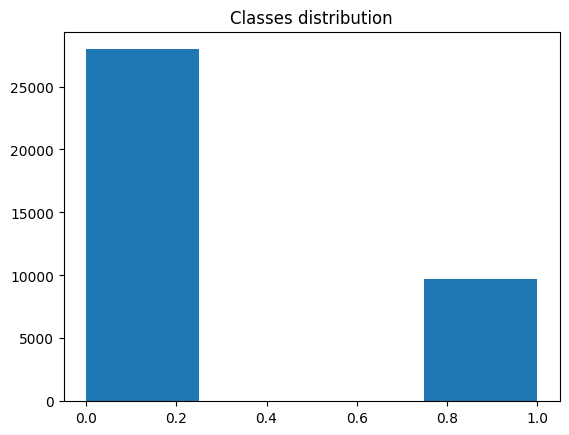

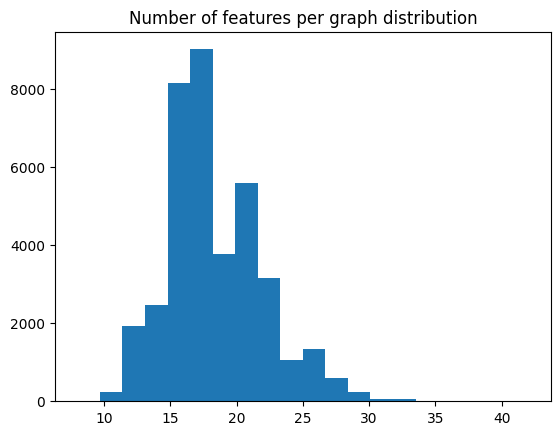

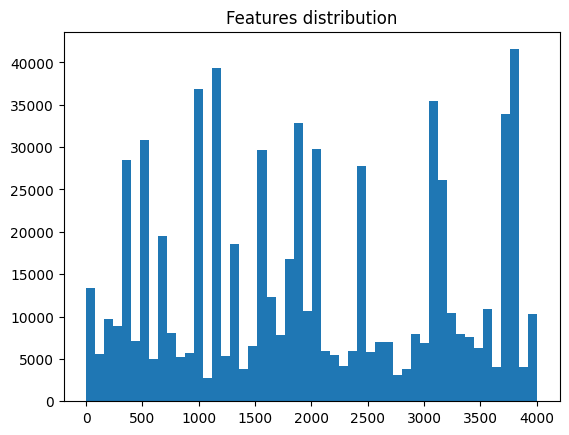

In [18]:
plt.hist(target_df.ml_target,bins=4,);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()

In [12]:
counter=collections.Counter(feats)
print(list(counter.keys())[:10])
print(list(counter.values())[:10])
print(list(counter.keys())[-10:])
print(list(counter.values())[-10:])
#data_encoded

[1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045]
[5045, 12726, 2486, 298, 165, 510, 22075, 28188, 24958, 21449]
[936, 172, 875, 3548, 2745, 793, 1941, 464, 2616, 3124]
[1, 2, 1, 2, 1, 1, 1, 1, 1, 1]


### collections.Counter is counting how many times each feature appears in the feats list.<br>
feats: This list contains all the features (integers) from all nodes.<br>
counter: The Counter object holds the unique features as keys, and the values represent how many times each feature appears across all nodes.

In [13]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

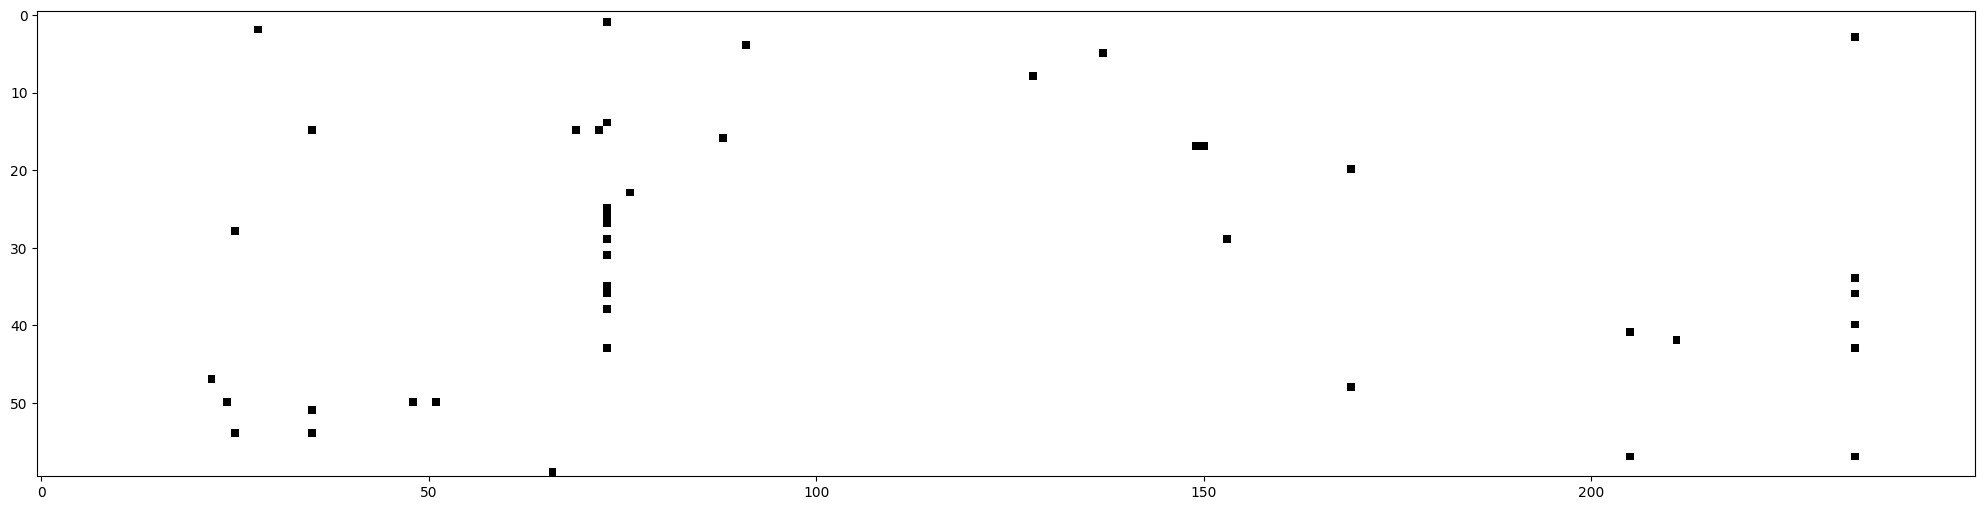

In [14]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');
#plt.grid()

In [15]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [16]:
#g_top_draw = Data(x=node_features, y=node_labels, edge_index=edge_index0)

def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

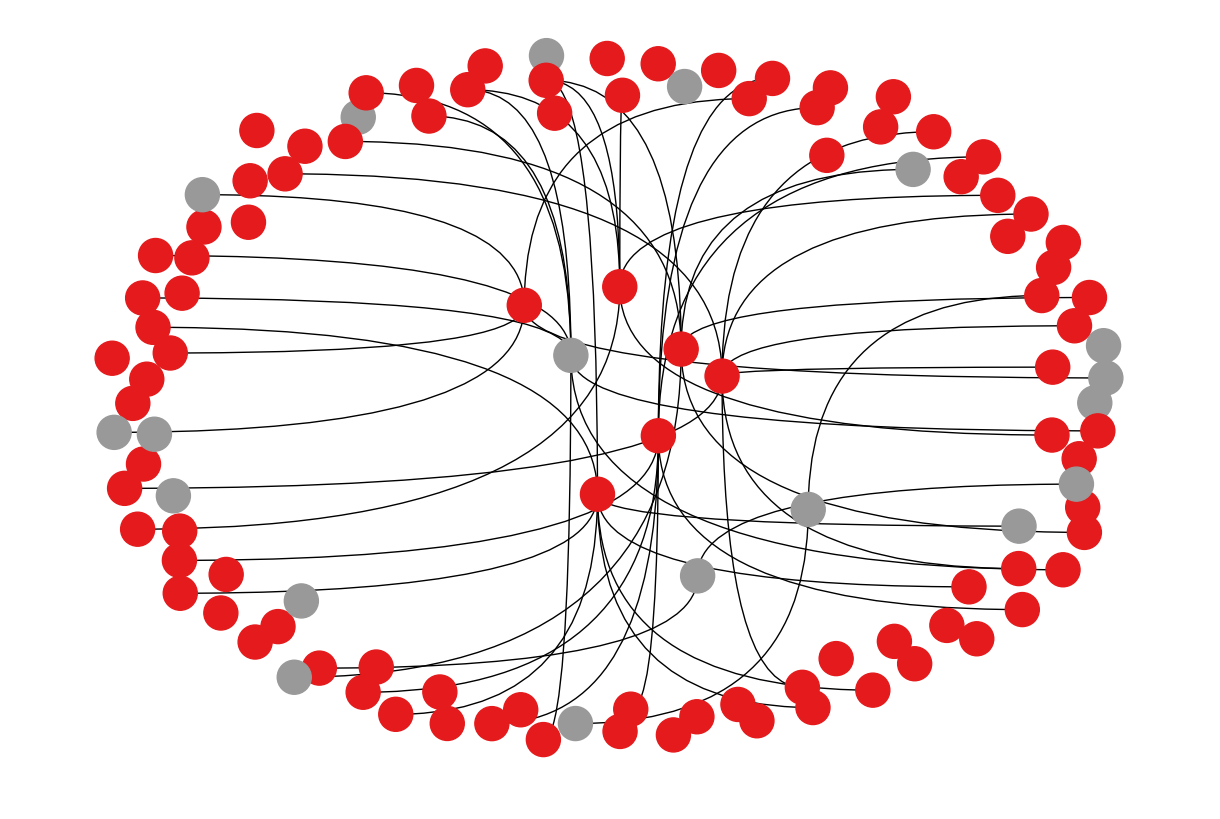

In [17]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)